In [1]:
import pandas as pd
df = pd.read_csv(f'C:/Users/A/Downloads/Fraud.csv')
print(df.isnull().sum())
df = df.drop(['type', 'nameDest', 'nameOrig'], axis=1)
df=df.dropna()
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
step              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [2]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.01)
outliers = iso_forest.fit_predict(df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])
df['outlier'] = outliers
df_clean = df[df['outlier'] == 1]

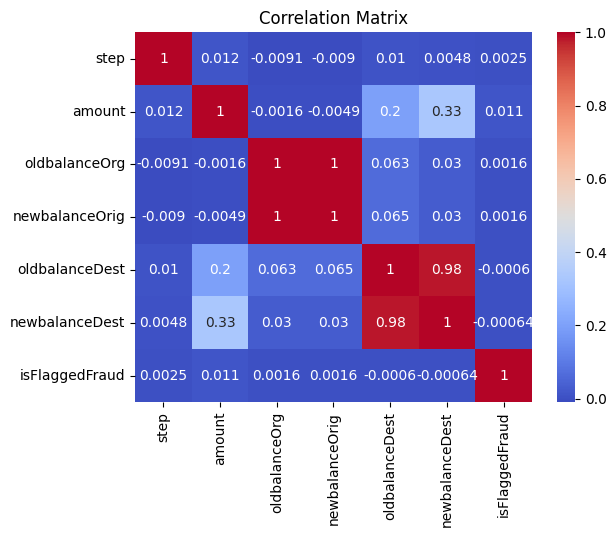

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df_clean[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest','isFlaggedFraud']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [4]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
X = df_clean[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest','isFlaggedFraud']]
y = df_clean['isFraud']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
}
model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=1000,
)


[LightGBM] [Info] Number of positive: 4616, number of negative: 3774780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.523815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 3779396, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001221 -> initscore=-6.706569
[LightGBM] [Info] Start training from score -6.706569


In [5]:
importances = model.feature_importance()
feature_names = X.columns
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(importances_df)

          Feature  Importance
0            step        7633
2   oldbalanceOrg        7098
1          amount        6926
5  newbalanceDest        3639
4  oldbalanceDest        3300
3  newbalanceOrig        1404
6  isFlaggedFraud           0


In [6]:
y_test_pred = model.predict(X_test)
y_test_pred_binary = [1 if x > 0.5 else 0 for x in y_test_pred]

accuracy = accuracy_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)
class_report = classification_report(y_test, y_test_pred_binary)
roc_auc = roc_auc_score(y_test, y_test_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Test Accuracy: 0.9992
Confusion Matrix:
[[1257716     555]
 [    444    1084]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1258271
           1       0.66      0.71      0.68      1528

    accuracy                           1.00   1259799
   macro avg       0.83      0.85      0.84   1259799
weighted avg       1.00      1.00      1.00   1259799

ROC AUC Score: 0.9354


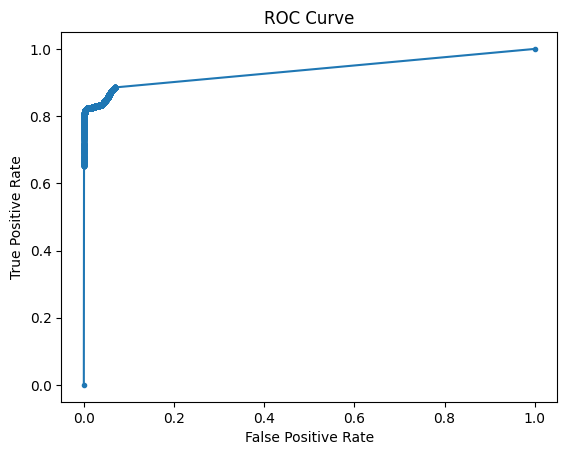

In [7]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt

X = df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest','isFlaggedFraud']]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_test_cleaned = y_test.dropna()

X_test_cleaned = X_test.loc[y_test_cleaned.index]

model = lgb.LGBMClassifier(class_weight='balanced')
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test_cleaned)

y_test_pred_binary = [1 if x > 0.5 else 0 for x in y_test_pred]

accuracy = accuracy_score(y_test_cleaned, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test_cleaned, y_test_pred_binary)
class_report = classification_report(y_test_cleaned, y_test_pred_binary)
roc_auc = roc_auc_score(y_test_cleaned, y_test_pred_binary)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print(f"ROC AUC Score: {roc_auc:.4f}")


[LightGBM] [Info] Number of positive: 6593, number of negative: 5083503
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.792569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Test Accuracy: 0.9933
Confusion Matrix:
[[1262322    8582]
 [      6    1614]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270904
           1       0.16      1.00      0.27      1620

    accuracy                           0.99   1272524
   macro avg       0.58      0.99      0.63   1272524
weighted avg       1.00      0.99      1.00   1272524

ROC AUC Score: 0.9948


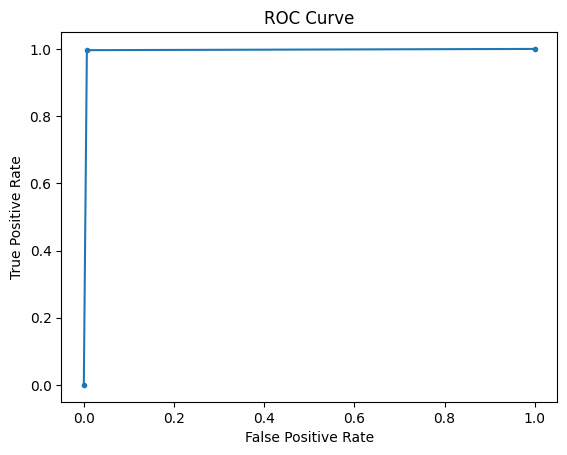

Test Accuracy: 99.3251


In [9]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_cleaned, y_test_pred_binary)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print(f"Test Accuracy: {accuracy*100:.4f}")

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_pred_binary = [1 if x > 0.99 else 0 for x in y_pred]

conf_matrix = confusion_matrix(y_test, y_pred_binary)
class_report = classification_report(y_test, y_pred_binary)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_binary)
print(f"ROC AUC Score: {roc_auc:.4f}")

Confusion Matrix:
[[1262322    8582]
 [      6    1614]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270904
           1       0.16      1.00      0.27      1620

    accuracy                           0.99   1272524
   macro avg       0.58      0.99      0.63   1272524
weighted avg       1.00      0.99      1.00   1272524

ROC AUC Score: 0.9948


In [17]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
df = pd.read_csv(f'C:/Users/A/Downloads/Fraud.csv')
print(df['isFraud'].isnull().sum())
df.dropna(subset=['isFraud'], inplace=True)
X = df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest','isFlaggedFraud']]
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = lgb.LGBMClassifier(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.4f}")

0
[LightGBM] [Info] Number of positive: 6593, number of negative: 5083503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Confusion Matrix:
[[1262322    8582]
 [      6    1614]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270904
           1       0.16      1.00      0.27      1620

    accuracy                           0.99   1272524
   macro avg       0.58      0.99      0.63   1272524
weighted avg       1.00      0.99      1.00   1272524

ROC AUC Score: 0.9948
